In [32]:
# Imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.utils import to_categorical
import pandas as pd
import random as rd



# 1 -  Getting started 

In [3]:

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]




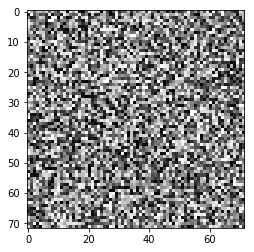

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

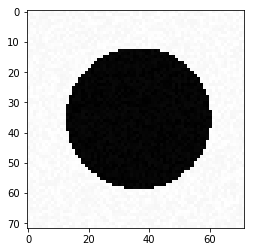

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

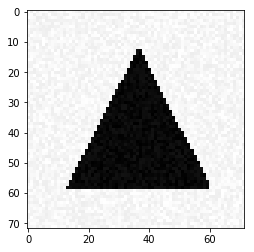

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [6]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [7]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



In [82]:
# Plot functions 

def plot_history(history):
    """Plots the accuracy and the loss for the training and validation sets"""
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# 2 - Simple Classification 

## Data preparation 

In [9]:
# Generating a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [10]:
# Convert target to catogorical 
target = to_categorical(Y_train,3)

## Linear classifier 



### 1 - SGD Optimizer

In [11]:
# Model construction  with SGD optimizer
model_sgd = Sequential()
model_sgd.add(Dense(3, activation='softmax', input_shape= ( X_train.shape[1],)))
model_sgd.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [12]:
model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model_sgd.fit(X_train, target, epochs=20,  validation_split = 0.20)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 579us/step - loss: 6.8306 - acc: 0.3750 - val_loss: 8.4015 - val_acc: 0.4167
Epoch 2/20
240/240 [==============================] - 0s 87us/step - loss: 7.5563 - acc: 0.3958 - val_loss: 8.9413 - val_acc: 0.2667
Epoch 3/20
240/240 [==============================] - 0s 103us/step - loss: 7.6590 - acc: 0.4042 - val_loss: 7.5590 - val_acc: 0.3500
Epoch 4/20
240/240 [==============================] - 0s 93us/step - loss: 8.1992 - acc: 0.3333 - val_loss: 8.5401 - val_acc: 0.4000
Epoch 5/20
240/240 [==============================] - 0s 98us/step - loss: 7.1168 - acc: 0.3708 - val_loss: 10.6238 - val_acc: 0.2667
Epoch 6/20
240/240 [==============================] - 0s 99us/step - loss: 7.2885 - acc: 0.4333 - val_loss: 9.1924 - val_acc: 0.2667
Epoch 7/20
240/240 [==============================] - 0s 96us/step - loss: 8.5780 - acc: 0.3292 - val_loss: 9.2206 - val_acc: 0.4000
Epoch 8/20
240/240 [=

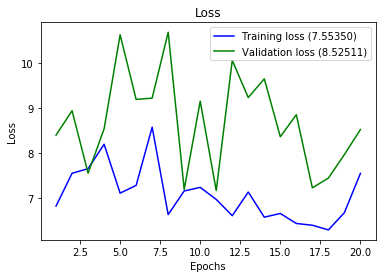

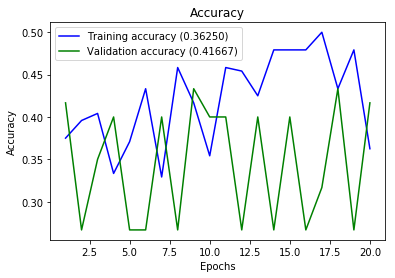

In [14]:
plot_history(history)

In [16]:
# Test the model 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_sgd.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

We notice that we don't reach the convergence using the SGD optimizer. 


### 2 - Adam Optimizer

In [31]:
# Model construction  with Adam optimizer
model_adam = Sequential()
model_adam.add(Dense(3, activation='softmax', input_shape= (X_train.shape[1],)))
model_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
model_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist2 = model_adam.fit(X_train, target, epochs=25,  validation_split = 0.25, batch_size = 32)

Train on 225 samples, validate on 75 samples
Epoch 1/25
225/225 [==============================] - 0s 976us/step - loss: 2.0328 - acc: 0.3644 - val_loss: 1.3588 - val_acc: 0.5333
Epoch 2/25
225/225 [==============================] - 0s 186us/step - loss: 1.2738 - acc: 0.5644 - val_loss: 0.9110 - val_acc: 0.7067
Epoch 3/25
225/225 [==============================] - 0s 113us/step - loss: 0.8141 - acc: 0.7289 - val_loss: 0.5269 - val_acc: 0.8267
Epoch 4/25
225/225 [==============================] - 0s 119us/step - loss: 0.4836 - acc: 0.8311 - val_loss: 0.4651 - val_acc: 0.8667
Epoch 5/25
225/225 [==============================] - 0s 121us/step - loss: 0.5305 - acc: 0.7689 - val_loss: 0.3612 - val_acc: 0.8667
Epoch 6/25
225/225 [==============================] - 0s 119us/step - loss: 0.5899 - acc: 0.8178 - val_loss: 0.3393 - val_acc: 0.8133
Epoch 7/25
225/225 [==============================] - 0s 115us/step - loss: 0.3258 - acc: 0.8667 - val_loss: 0.2977 - val_acc: 0.9067
Epoch 8/25
225/22

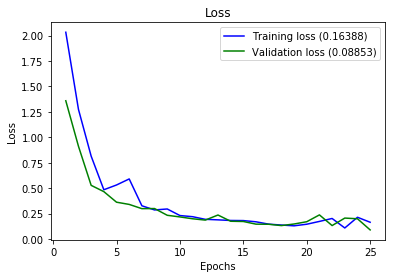

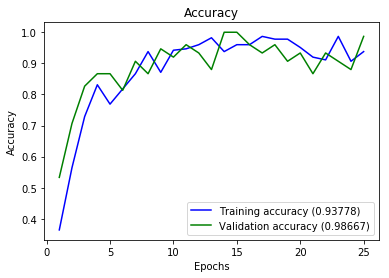

In [34]:
plot_history(hist2)

In [35]:
# Test the model 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [36]:
model_adam.evaluate(X_train, target)

300/300 [==============================] - 0s 50us/step


[0.09030198554197948, 0.99]

The model with Adam Optimizer gives a good prediction. And after only 25 epochs, we have an very good accuracy.

# 3 -  Visualization of the solution 


In [37]:
weights_sgd = model_sgd.get_weights()[0]
weights_sgd.shape

(5184, 3)

In [38]:
weights_adam = model_adam.get_weights()[0]
weights_adam.shape

(5184, 3)

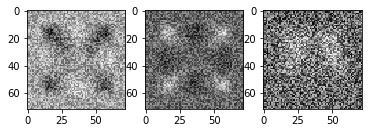

In [44]:
fig = plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(weights_sgd[:,0].reshape(72,72), cmap='gray')  # Rectangle
fig.add_subplot(1,3,2)
plt.imshow(weights_sgd[:,1].reshape(72,72), cmap='gray')  # Disk
fig.add_subplot(1,3,3)
plt.imshow(weights_sgd[:,2].reshape(72,72), cmap='gray')  # Triangle

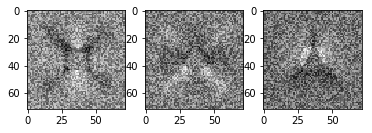

In [45]:
fig = plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(weights_adam[:,0].reshape(72,72), cmap='gray')  # Rectangle
fig.add_subplot(1,3,2)
plt.imshow(weights_adam[:,1].reshape(72,72), cmap='gray')  # Disk
fig.add_subplot(1,3,3)
plt.imshow(weights_adam[:,2].reshape(72,72), cmap='gray')  # Triangle

# 5 - More difficult classification problem 

In this part, the shapes are allowed to move within the images and change dimensions.

In [139]:
# Generate a new training set 
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [140]:
# one-hot encode target column 
target = to_categorical(Y_train,3)

## Linear model

In [141]:
# Model construction  with Adam optimizer
model_adam = Sequential()
model_adam.add(Dense(3, activation='softmax', input_shape= (X_train.shape[1],)))
model_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [142]:
hist = model_adam.fit(X_train, target, epochs=50,  validation_split = 0.20, batch_size = 32)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 995us/step - loss: 1.5828 - acc: 0.3912 - val_loss: 0.9649 - val_acc: 0.4750
Epoch 2/50
800/800 [==============================] - 0s 88us/step - loss: 1.0351 - acc: 0.4637 - val_loss: 1.0273 - val_acc: 0.4500
Epoch 3/50
800/800 [==============================] - 0s 83us/step - loss: 0.9291 - acc: 0.5200 - val_loss: 0.8369 - val_acc: 0.5550
Epoch 4/50
800/800 [==============================] - 0s 84us/step - loss: 0.9672 - acc: 0.5125 - val_loss: 0.8230 - val_acc: 0.5500
Epoch 5/50
800/800 [==============================] - 0s 89us/step - loss: 0.8654 - acc: 0.5550 - val_loss: 0.9365 - val_acc: 0.5700
Epoch 6/50
800/800 [==============================] - 0s 85us/step - loss: 1.0432 - acc: 0.5587 - val_loss: 1.6371 - val_acc: 0.3000
Epoch 7/50
800/800 [==============================] - 0s 89us/step - loss: 1.0237 - acc: 0.5162 - val_loss: 0.7816 - val_acc: 0.6400
Epoch 8/50
800/800 [==

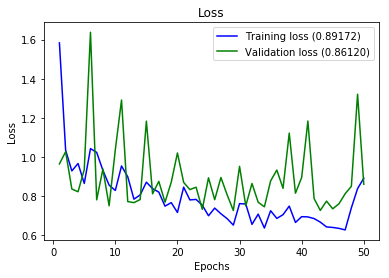

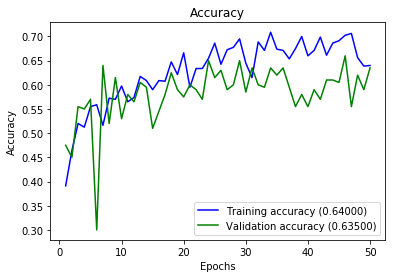

In [143]:
plot_history(hist)

In [144]:
# Generate test set 
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [145]:
model_adam.evaluate(X_test, Y_test, batch_size=32)

300/300 [==============================] - 0s 64us/step


[0.925968976020813, 0.61]

We have an low accuracy on the test set.

## Convolutional (not to) deep network



In [146]:
#reshape data to fit model
X_train = X_train.reshape(X_train.shape[0],72,72,1)
X_test = X_test.reshape(X_test.shape[0],72,72,1)

In [147]:
X_train.shape  , X_test.shape


((1000, 72, 72, 1), (300, 72, 72, 1))

In [2]:
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D

conv_model = Sequential()
#add model layers
conv_model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
conv_model.add(MaxPooling2D((2,2)))
conv_model.add(Flatten())
conv_model.add(Dense(3, activation ='softmax'))
conv_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [149]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________


In [150]:
hist = conv_model.fit(X_train, target, epochs=50, validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 3s 3ms/step - loss: 1.0483 - acc: 0.4962 - val_loss: 0.8585 - val_acc: 0.7050
Epoch 2/50
800/800 [==============================] - 2s 3ms/step - loss: 0.7804 - acc: 0.7100 - val_loss: 0.7094 - val_acc: 0.6450
Epoch 3/50
800/800 [==============================] - 2s 3ms/step - loss: 0.6620 - acc: 0.7475 - val_loss: 0.6525 - val_acc: 0.6800
Epoch 4/50
800/800 [==============================] - 2s 3ms/step - loss: 0.6194 - acc: 0.7612 - val_loss: 0.5988 - val_acc: 0.7550
Epoch 5/50
800/800 [==============================] - 2s 3ms/step - loss: 0.5491 - acc: 0.7913 - val_loss: 0.6111 - val_acc: 0.7050
Epoch 6/50
800/800 [==============================] - 3s 3ms/step - loss: 0.5173 - acc: 0.8087 - val_loss: 0.5386 - val_acc: 0.8200
Epoch 7/50
800/800 [==============================] - 2s 3ms/step - loss: 0.4537 - acc: 0.8588 - val_loss: 0.5064 - val_acc: 0.7950
Epoch 8/50
800/800 [==========

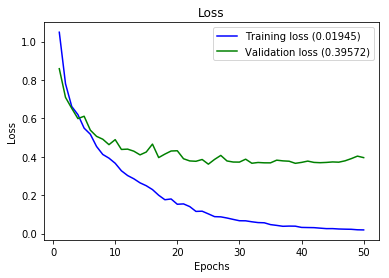

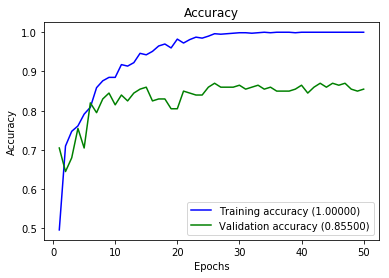

In [151]:
plot_history(hist)

In [152]:
conv_model.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 1ms/step


[0.5300012648105621, 0.823333334128062]

We have improved the accuracy of our model by adding other layers

# 6 -  A Regression Problem 

I this part, we try to detect the position of the edges of a triangle. 


In [264]:
# Generate regression dataset
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


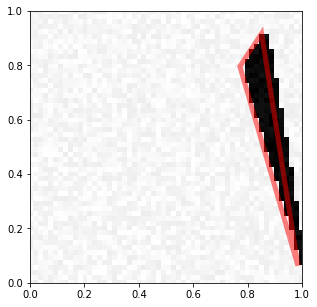

In [265]:
  visualize_prediction(X_train[7], Y_train[7])

In [295]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_test, Y_test] = generate_test_set_regression()

# Reshape X    
X_train = X_train.reshape((X_train.shape[0],72,72,1))
X_test = X_test.reshape((X_test.shape[0],72,72,1))

# Normalizing Y 
Y_train_norm = np.zeros(Y_train.shape)
Y_ordered = np.argsort(Y_train[:,::2], axis=1)

for i in range(Y_train.shape[0]):
    Y_train_norm[i, ::2] = Y_train[i, Y_ordered[i]*2]
    Y_train_norm[i, 1::2] = Y_train[i, Y_ordered[i]*2 + 1]
    
Y_test_norm = np.zeros(Y_test.shape)
Y_ordered1 = np.argsort(Y_test[:,::2], axis=1)

for i in range(Y_test.shape[0]):
    Y_test_norm[i, ::2] = Y_test[i, Y_ordered1[i]*2]
    Y_test_norm[i, 1::2] = Y_test[i, Y_ordered1[i]*2 + 1]

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [40]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,AveragePooling2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)))
model.add(MaxPooling2D((2,2), strides=2))
model.add(Conv2D(32, (5, 5), activation='relu',))
model.add(MaxPooling2D((2,2), strides=2))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer='adam', loss="mean_squared_error",metrics=['accuracy'])

In [331]:
history = model.fit(X_train, Y_train_norm, validation_split=0.2, epochs=50, batch_size=64, verbose=0)

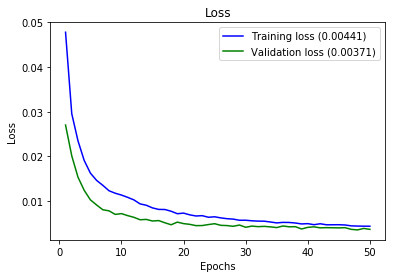

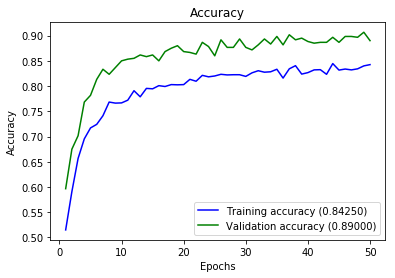

In [332]:
plot_history(history)

In [333]:
model.evaluate(X_test_reg, Y_test_norm)

300/300 [==============================] - 1s 2ms/step


[0.004553969005743662, 0.8866666658719381]

In [334]:
Y_pred = model.predict(X_test_reg)

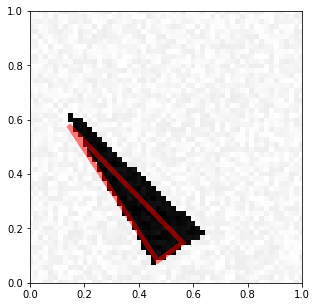

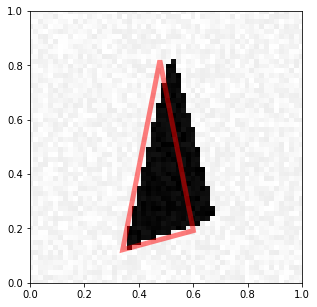

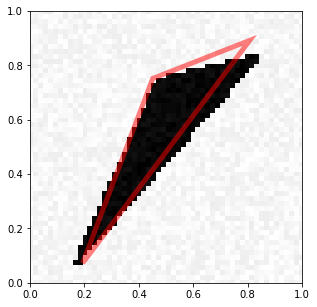

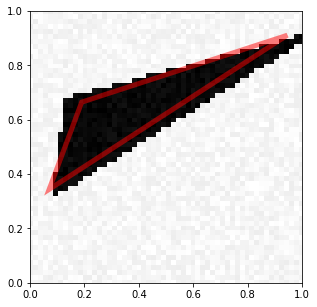

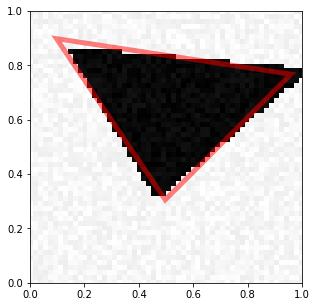

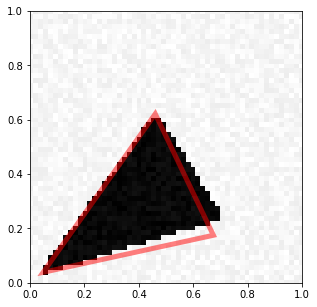

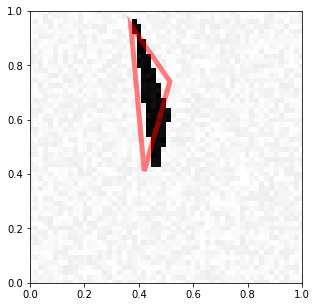

In [335]:
idx_list = [15, 57, 100, 167, 200, 69, 27]
for i in idx_list :
    visualize_prediction(X_test_reg[i], Y_pred[i])

The regressor we build gives good results. 
The accuracy of the test set is close to the accuracy of the training  and validation sets, so we can say that our regressor learns well and doesn't overfit. 

# 7 - Image Denoising 

In [4]:
def generate_noisy_rectangle(noise, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)


def generate_noisy_disk(noise, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)

def generate_noisy_triangle(noise, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, 0)
    return [imdata, generate_a_drawing(figsize, U, V, noise), [U[0], V[0], U[1], V[1], U[2], V[2]]]




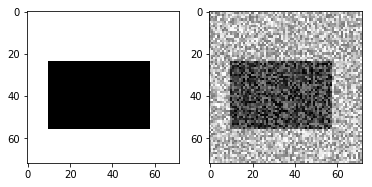

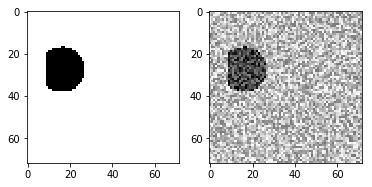

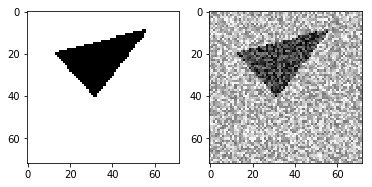

In [5]:
# Generating functions 
image, noisy_image = generate_noisy_rectangle(noise=300,free_location=True)
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(72,72), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(noisy_image.reshape(72,72), cmap='gray')
plt.show()
image, noisy_image = generate_noisy_disk(noise = 300, free_location=True)
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(72,72), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(noisy_image.reshape(72,72), cmap='gray')
plt.show()
[image, noisy_image, v] = generate_noisy_triangle(noise = 300, free_location=True)
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(72,72), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(noisy_image.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [6]:
def generate_noisy_dataset(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_noisy_rectangle(0)[0].shape[0]
    #images without noise
    X = np.zeros([nb_samples,im_size])
    #noisy images
    Y = np.zeros([nb_samples,im_size])   
    for i in range(nb_samples):
        category = np.random.randint(3)
        
        noise =rd.randint(50,500)
        if category == 0:
            X[i] , Y[i]= generate_noisy_rectangle(noise, free_location)
        elif category == 1: 
            X[i] , Y[i]= generate_noisy_disk(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_noisy_triangle(noise, free_location)
    X = (X + 0) / (255 + 2 * 0)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]

In [45]:
[X_train_n, Y_train_n] = generate_noisy_dataset(300)
[X_test_n, Y_test_n] = generate_noisy_dataset(300)

X_train_n = X_train_n.reshape(X_train_n.shape[0], 72, 72, 1)
X_test_n = X_test_n.reshape(X_test_n.shape[0], 72, 72, 1)

Y_train_n = Y_train_n.reshape(Y_train_n.shape[0], 72, 72, 1)
Y_test_n = Y_test_n.reshape(Y_test_n.shape[0], 72, 72, 1)


### Hourglass model

In [78]:
input_img = Input(shape=(72,72,1))

# hourglass network 

#  encoder :  convolutional layer + a pool layer
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2))(x)

# decoder : unsampling layer + convolutional layer
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

denoise_model = Model(input_img, decoded)
denoise_model.compile(optimizer='adam', loss='binary_crossentropy')
denoise_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 36, 36, 32)        9248      
_________________________________________________________________
up_sampling2d_36 (UpSampling (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 72, 72, 1)         289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = denoise_model.fit(X_train_n, Y_train_n, epochs=50,validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 3s 12ms/step - loss: 0.5960 - val_loss: 0.5956
Epoch 2/50
240/240 [==============================] - 3s 12ms/step - loss: 0.5958 - val_loss: 0.5957
Epoch 3/50
240/240 [==============================] - 3s 11ms/step - loss: 0.5958 - val_loss: 0.5951
Epoch 4/50
240/240 [==============================] - 3s 12ms/step - loss: 0.5960 - val_loss: 0.5951
Epoch 5/50
240/240 [==============================] - 3s 11ms/step - loss: 0.5959 - val_loss: 0.5951
Epoch 6/50
240/240 [==============================] - 3s 11ms/step - loss: 0.5957 - val_loss: 0.5951
Epoch 7/50
240/240 [==============================] - 3s 11ms/step - loss: 0.5960 - val_loss: 0.5955
Epoch 8/50
240/240 [==============================] - 3s 11ms/step - loss: 0.5960 - val_loss: 0.5950
Epoch 9/50
240/240 [==============================] - 3s 11ms/step - loss: 0.5958 - val_loss: 0.5950
Epoch 10/50
240/240 [=========================

No handles with labels found to put in legend.


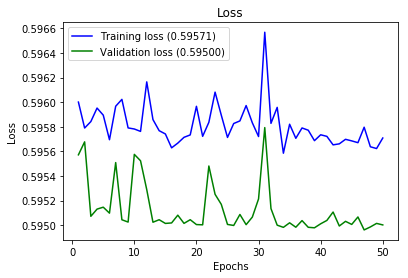

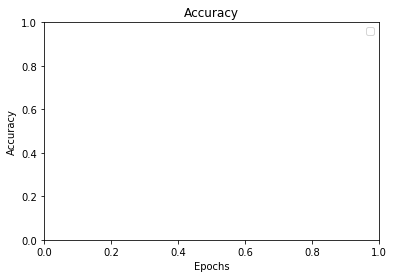

In [83]:
plot_history(history )

In [84]:
denoise_model.evaluate(X_test_n, Y_test_n)

300/300 [==============================] - 1s 4ms/step


0.5661824059486389

In [85]:
Y_predicted = denoise_model.predict(X_test_n)

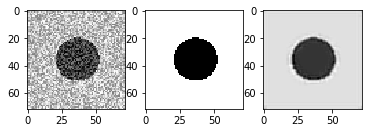

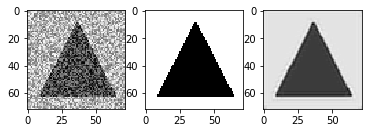

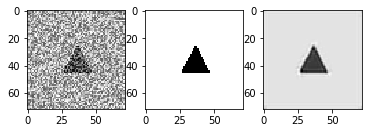

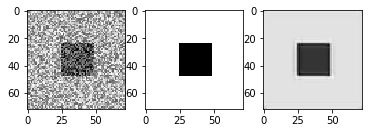

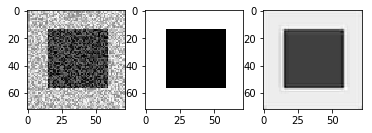

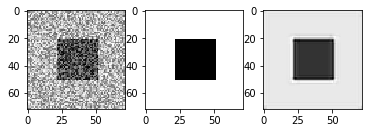

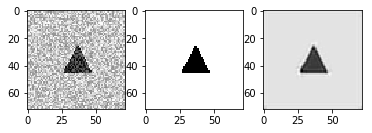

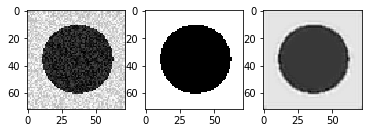

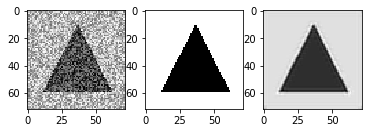

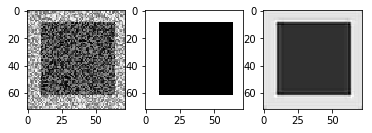

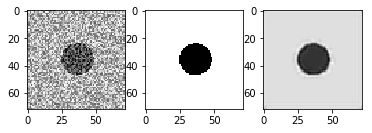

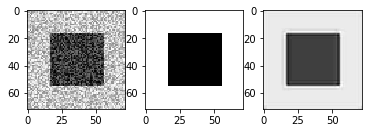

In [87]:
N = 10
for i, (im, noisy_im, pred_im) in enumerate(zip(Y_test_n, X_test_n, Y_predicted)):
    plt.subplot(1, 3, 1)
    plt.imshow(im.reshape(72,72), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_im.reshape(72,72), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_im.reshape(72,72), cmap='gray')
    plt.show()
    if i > N:
        break

We can see that our model can reduce the noise in the images. 